In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.290216  0.467480  0.176922  0.303856  0.225660 -0.908991  0.628747   
  1   0.295939  0.120450  1.920947  0.892463  0.051143 -0.267078  0.418463   
  2  -0.464911  0.084136  0.214872  0.999685  0.740530  0.181939  0.355530   
  3  -0.334593  0.914453  0.347348  0.135196 -2.068523  0.069496 -0.193801   
  4  -0.140816  0.196331  0.380817  0.814614  0.422506 -0.061350  0.026042   
  5   0.077193 -0.230792  0.505256  0.995030 -1.031491 -0.570202 -0.105996   
  6  -0.529626  0.985737 -0.073239  1.100508 -0.175529  0.236316  0.349925   
  7  -0.285059  0.235847 -0.247933  1.417092  0.380752  1.110458  0.470164   
  8   0.319144  0.220665  0.347858  0.604691 -0.991605 -0.260608  0.396397   
  9   0.739299  0.301473  0.733576  0.157198 -0.394954 -0.347150 -0.487849   
  10  0.199678  0.677508 -0.141185  0.835550  0.043161 -0.058012  0.304182   
  11 -0.278132 -0.150569  0.343086  0.200221 -0.740673  0.682541  0.151418   
  12 -0.180892  1.101095 -0.027758  0.063748 -0.410294 -0.409913 -0.451964   
  13 -0.095341  0.257143 -0.697656 -0.188631  0.537131  0.523446  0.022248   
  14 -0.212253 -0.201802  0.919986 -0.088383  0.739983  0.010211  0.522819   
  15  1.227280 -0.199595  0.216576  0.741559  0.018287  0.083078  0.755848   
  16 -0.800105 -0.441289 -0.140027  0.345174  0.397914  0.891290  1.104344   
  17  0.840256  1.051408  0.279678  0.870428  0.527965  0.644334  0.117085   
  18  0.806178  0.066357  0.241905  0.070964 -0.772904  0.189387  0.333486   
  19 -0.209544  1.095778 -0.229864  0.194812 -1.062924  0.606288  0.762275   
  20 -1.288037  0.339792  0.108665 -0.030342 -1.118451  0.064141  0.160439   
  21 -0.252592  0.745680 -0.070439 -0.021879  0.202504  0.769932  0.013796   
  22 -0.543107  0.483635 -0.364364  0.646457 -0.633316  0.307075  0.586091   
  23  0.284048  0.947370  0.246198  0.824015  0.113465  1.040998  1.643063   
  24  0.469183  0.388701  0.287471  0.385277  0.033249 -0.231475 -0.434433   
1 0  -0.130063 -0.467748 -0.028041 -0.826708  0.385012  0.211587  1.409466   
  1   0.057199  0.378319  0.493957 -0.191312  0.680892 -0.286521  0.454713   
  2  -0.059030  0.107457 -0.912953 -0.743330 -0.482993 -0.569247  0.559150   
  3   0.453163  0.557639  0.414219 -0.035723  0.333969 -0.147887  0.620978   
  4  -0.365866 -0.011121 -0.762049 -1.722151  0.371033  0.465983  0.436012   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   1.152284  0.959479  0.359100  ... -0.341202 -0.063562 -1.429058   
  1   0.378441  1.063053  0.757607  ... -1.174125 -0.882748  0.298628   
  2  -0.548176 -0.445137 -0.263965  ...  1.209077  0.127627 -0.035633   
  3  -0.263934  0.160187 -0.293100  ...  0.284486 -0.226388  0.568146   
  4  -0.323086  0.203050  0.525613  ... -0.614806  0.272254 -0.922451   
  5   0.126586  1.199219 -0.082544  ...  1.171077  0.323774 -0.635613   
  6  -0.153768  0.051790 -0.381552  ...  0.061764  0.406207 -0.380578   
  7  -0.077365 -0.692004 -0.680969  ...  0.011998  0.712424  0.357646   
  8  -0.408095 -0.039031  0.074417  ... -0.051439  0.221008 -0.627705   
  9  -0.107844 -0.703963  0.908090  ...  0.447073 -0.542908 -0.557666   
  10 -0.423726 -0.678655 -0.186689  ... -0.769401 -0.319105 -0.435721   
  11 -0.168019 -0.247610  0.254202  ... -0.937159 -1.598696 -0.414227   
  12 -0.103336 -0.823232  0.238993  ... -0.243271  0.236219 -0.807044   
  13  0.013304  0.121980  0.297234  ...  0.295532 -0.618725 -0.378704   
  14  0.074553 -0.031651  0.390547  ... -0.142082 -0.315989 -0.626277   
  15 -0.988090  0.121663 -0.764643  ... -1.038659  0.524824  0.212893   
  16 -0.178588 -0.099223 -0.299194  ...  0.639717 -0.196587 -0.323292   
  17  0.089476 -0.190560  0.925778  ... -0.082272  0.140402  1.001800   
  18  0.378248  0.174344  0.130162  ...  1.006551 -0.290558 -0.499810   
  19  0.425801 -0.902000 -0.804716  ...  0.459003 -0.589760 -0.413905   
  20  0.343929 -0.811673 -0.102886  ... -0.024723 -0.111365 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.172024  0.052377  22.376715  6.635734e-111  1.069367  1.274681


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



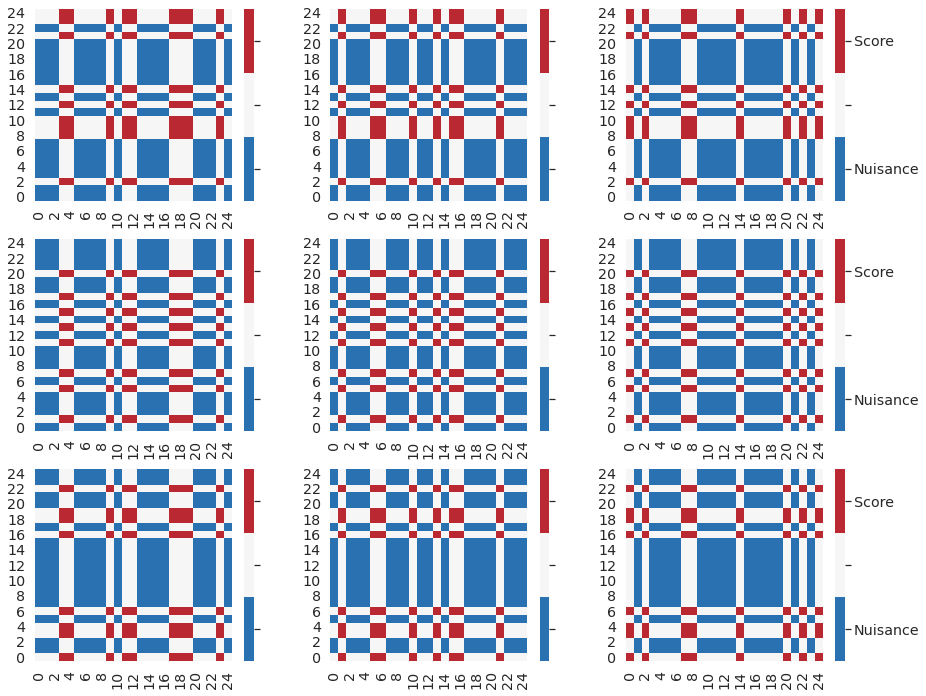

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



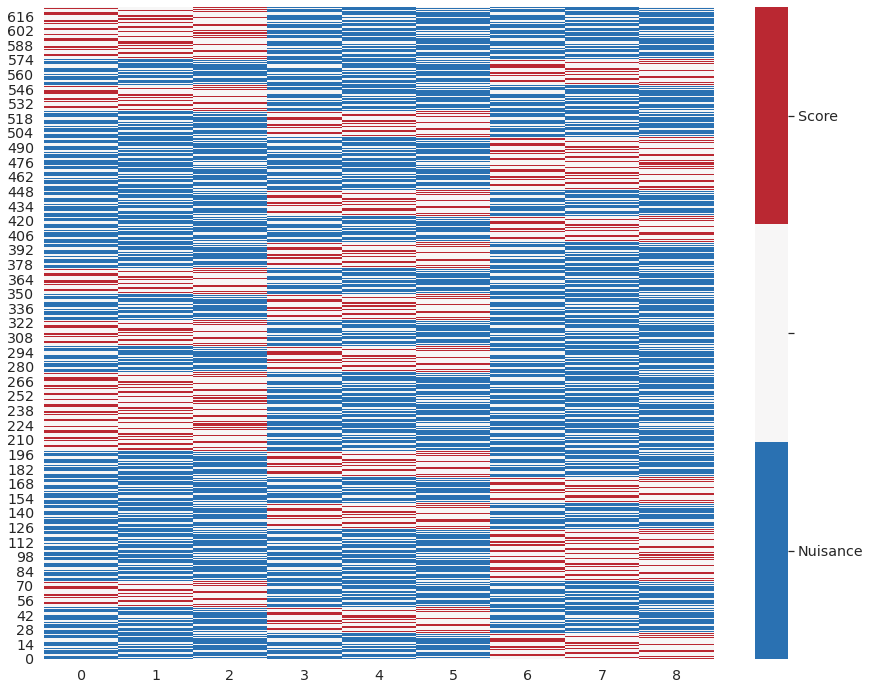

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])